<a href="https://colab.research.google.com/github/Javorai/Coding-Dojo-Core/blob/main/Modelos_basados_en_%C3%A1rbol_Predicci%C3%B3n_de_Precios_de_Veh%C3%ADculos_Usados_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción de Precios de Vehículos Usados (Core)**

implementar y evaluar modelos de regresión, y seleccionar el mejor modelo basado en las métricas de evaluación.

**Requisitos:**

1. **Carga y Exploración de Datos:**
* Descargar y cargar el dataset.
* Realizar una exploración inicial para entender la estructura del dataset.
* Identificar valores faltantes, duplicados y outliers.
2. **Limpieza y Preprocesamiento:**
* Manejar valores faltantes.
* Eliminar duplicados.
* Corregir inconsistencias en los datos categóricos.
* Escalar las características numéricas.
* Realizar transformaciones necesarias para las características categóricas.
3. **Exploración de Datos:**
* Crear visualizaciones univariadas y multivariadas.
* Calcular estadísticas descriptivas.
4. **Modelado y Evaluación:**
* Implementar al menos dos modelos de regresión (Linear Regression y Random Forest Regressor).
* Evaluar los modelos utilizando MSE, RMSE, y R^2.
* Seleccionar el mejor modelo basado en las métricas de evaluación.
5. **Optimización del Modelo:**
* Optimizar el modelo seleccionado utilizando GridSearchCV.

**Dataset:**

[Used Cars Dataset](https://www.kaggle.com/datasets/lepchenkov/usedcarscatalog)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


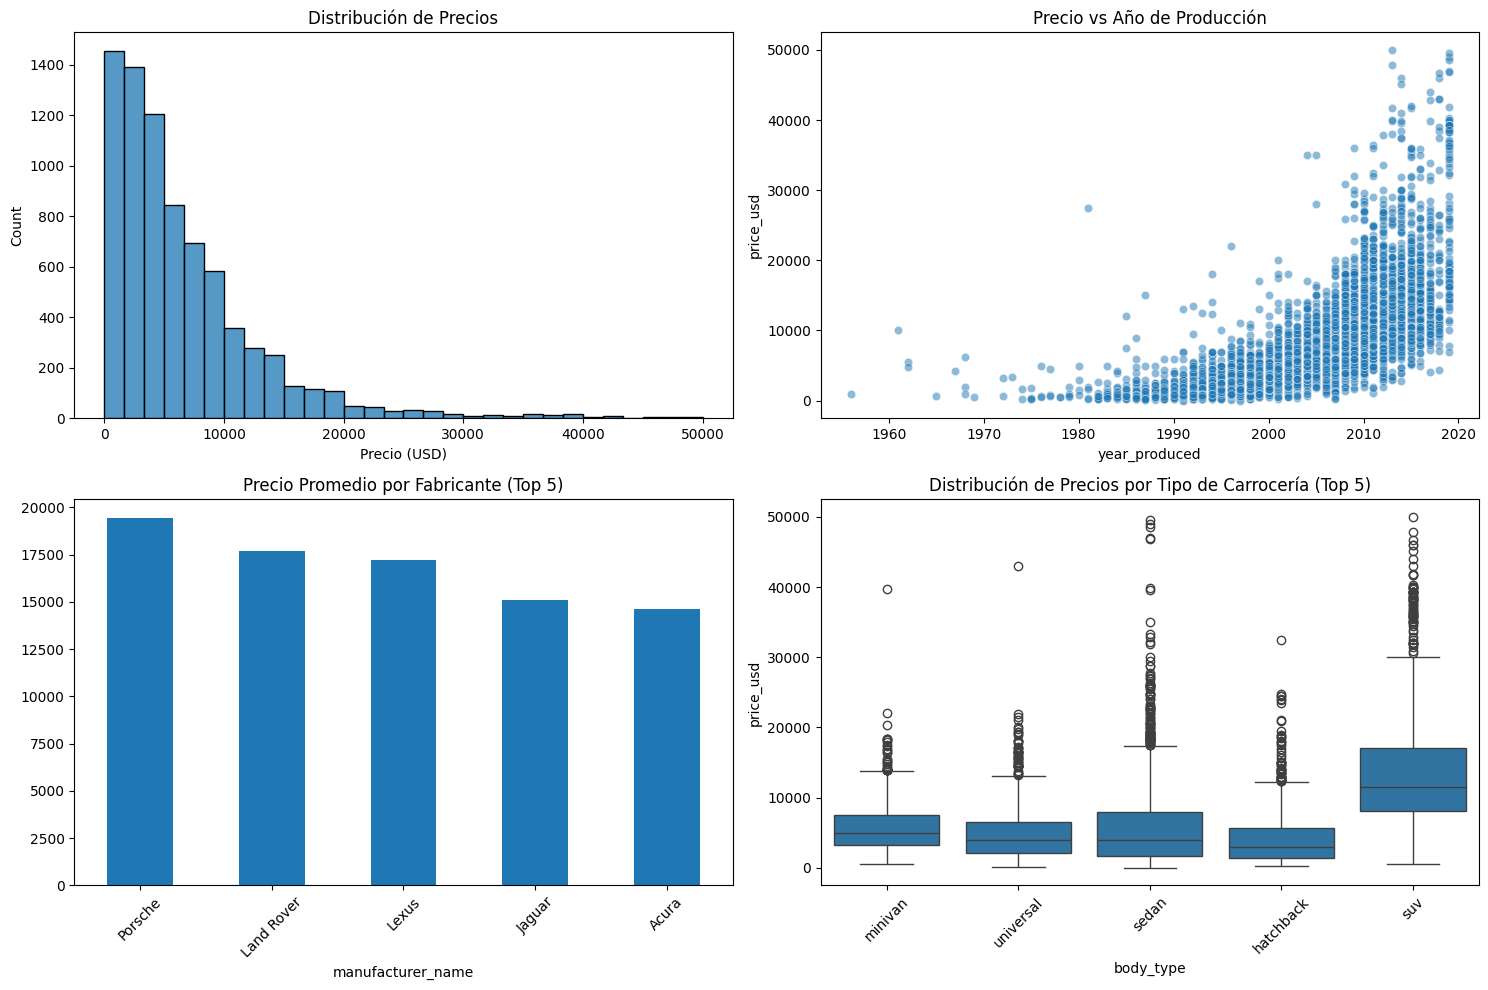

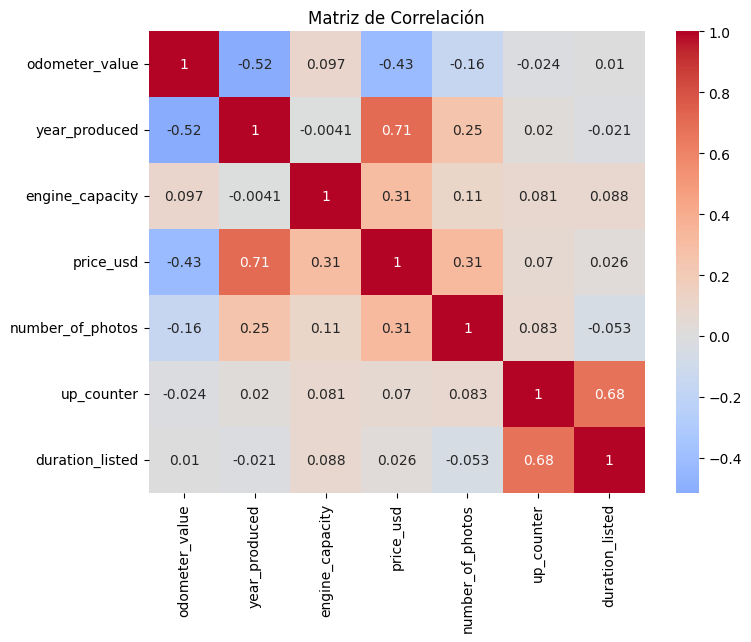


Resultados de los modelos:

Linear Regression:
Train MSE: 5205151.9708
Train RMSE: 2281.4802
Train R2: 0.8711
Test MSE: 273414863083191557987237888.0000
Test RMSE: 16535261203960.2070
Test R2: -6363688216868249600.0000

Random Forest:
Train MSE: 697170.3484
Train RMSE: 834.9673
Train R2: 0.9827
Test MSE: 5676323.4391
Test RMSE: 2382.5036
Test R2: 0.8679

Mejores parámetros para Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Mejor RMSE (cross-validation): 2253.2207


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# 1. Carga de datos desde Google Drive
from google.colab import drive
drive.mount('/content/drive')

URL = "/content/drive/MyDrive/Bootcamp Coding Dojo/DataScience/Tareas Core/Archivos CSV-Tareas/cars.csv"
df = pd.read_csv(URL)

# 2. Reducir el tamaño del dataset
def reduce_dataset(df, fraction=0.2, random_state=42):
    """
    Reduce the dataset to a smaller fraction while maintaining representation
    """
    df_reduced = df.sample(frac=fraction, random_state=random_state)
    return df_reduced

# 3. Limpieza y Preprocesamiento
def preprocess_data(df):
    # Crear una copia del DataFrame
    df_clean = df.copy()

    # Identificar columnas numéricas y categóricas
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.drop('price_usd')
    categorical_features = df.select_dtypes(include=['object']).columns

    # Crear pipeline de preprocesamiento
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(drop='first', sparse_output=False))
            ]), categorical_features)
        ])

    return preprocessor, numeric_features, categorical_features

# 4. Análisis Exploratorio de Datos (EDA)
def perform_eda(df):
    plt.figure(figsize=(15, 10))

    # Distribución de precios
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='price_usd', bins=30)
    plt.title('Distribución de Precios')
    plt.xlabel('Precio (USD)')

    # Relación precio vs año
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=df, x='year_produced', y='price_usd', alpha=0.5)
    plt.title('Precio vs Año de Producción')

    # Precio promedio por fabricante (top 5)
    plt.subplot(2, 2, 3)
    df.groupby('manufacturer_name')['price_usd'].mean().sort_values(ascending=False).head(5).plot(kind='bar')
    plt.title('Precio Promedio por Fabricante (Top 5)')
    plt.xticks(rotation=45)

    # Distribución de precios por tipo de carrocería (top 5)
    plt.subplot(2, 2, 4)
    top_5_body_types = df['body_type'].value_counts().head(5).index
    sns.boxplot(data=df[df['body_type'].isin(top_5_body_types)], x='body_type', y='price_usd')
    plt.title('Distribución de Precios por Tipo de Carrocería (Top 5)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Correlaciones entre variables numéricas (reduce la cantidad de columnas)
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(8, 6))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación')
    plt.show()

# 5. Modelado y Evaluación
def train_evaluate_models(X, y):
    # Reducir el tamaño del split de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear y entrenar modelos
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=42, n_estimators=50)
    }

    results = {}
    for name, model in models.items():
        # Entrenar modelo
        model.fit(X_train, y_train)

        # Predecir
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Calcular métricas
        results[name] = {
            'Train MSE': mean_squared_error(y_train, y_pred_train),
            'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'Train R2': r2_score(y_train, y_pred_train),
            'Test MSE': mean_squared_error(y_test, y_pred_test),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'Test R2': r2_score(y_test, y_pred_test)
        }

    return results

# 6. Optimización del Mejor Modelo
def optimize_random_forest(X, y):
    # Reducir la cantidad de parámetros a optimizar
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [10, None],
        'min_samples_split': [2, 5]
    }

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(
        rf,
        param_grid,
        cv=3,  # Reducir el número de folds de cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X, y)

    return grid_search.best_params_, grid_search.best_score_

# Ejecutar el análisis completo
def main():
    # 1. Reducir el dataset
    df_reduced = reduce_dataset(df)

    # 2. Preprocesamiento
    preprocessor, numeric_features, categorical_features = preprocess_data(df_reduced)

    # 3. Preparar datos para el modelo
    X = df_reduced.drop('price_usd', axis=1)
    y = df_reduced['price_usd']

    # 4. Realizar EDA
    perform_eda(df_reduced)

    # 5. Preprocesar datos
    X_processed = preprocessor.fit_transform(X)

    # 6. Entrenar y evaluar modelos
    results = train_evaluate_models(X_processed, y)

    # Mostrar resultados
    print("\nResultados de los modelos:")
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")

    # 7. Optimizar Random Forest
    best_params, best_score = optimize_random_forest(X_processed, y)
    print("\nMejores parámetros para Random Forest:")
    print(best_params)
    print(f"Mejor RMSE (cross-validation): {np.sqrt(-best_score):.4f}")

# Ejecutar el análisis
if __name__ == "__main__":
    main()